## Pytorch 深度學習影像辨識練習
#### Image Classification with Pytorch  

1. 載入所需資料庫

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils as utils
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import numpy as np
import os 
import time
import copy
import matplotlib.pyplot as plt
from matplotlib import style


2. 建立 Helper Function

* 資料集建立函式
<br>
###### &emsp;&emsp;&emsp;&emsp; 此函示建立訓練與驗證資料集(dict)，並包含資料的增補 (Data Augmentation)<br>&emsp;&emsp;&emsp;&emsp; <b>函式輸入:</b> 資料目標來源、轉置大小、切割比例<br> &emsp;&emsp;&emsp;&emsp; <b>函式輸出:</b> 含資料增補資料集(Data Loader)、資料集大小、類別標籤


In [3]:
def createDataset(data_dir, imgSize, splitRatio):
    # 建立訓練與驗證資料集的 Data Augmentation 
    data_transforms = {
        'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(imgSize),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    }

    fullset = datasets.ImageFolder(data_dir)
    train_size = int(len(fullset)*splitRatio)
    val_size = len(fullset) - train_size

    
    trainSet, valSet = utils.data.random_split(fullset,[train_size, val_size])
    trainSet.dataset.transform = data_transforms['train']
    valSet.dataset.transform = data_transforms['val']

    dataloaders = {Dataset_type: utils.data.DataLoader(Dataset,
    batch_size=4, shuffle=True)
    for Dataset_type, Dataset in zip(['train', 'val'], [trainSet, valSet])}

    dataset_sizes = {x: len(Dataset) for x, Dataset in zip(['train', 'val'], [trainSet, valSet])}
    classes_name = fullset.classes



    return dataloaders, dataset_sizes, classes_name


* 訓練函式
<br>
###### &emsp;&emsp;&emsp;&emsp; 此函示主要啟動訓練並輸出模型<br>&emsp;&emsp;&emsp;&emsp; <b>函式輸入:</b> 模型架構、損失函數、求解器、排程器<br> &emsp;&emsp;&emsp;&emsp; <b>函式輸出:</b> 模型


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())  # 複製pre-trained model 的 weight, bias
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

* 結果視覺化函式
<br>
###### &emsp;&emsp;&emsp;&emsp; 此函示主要輸出模型辨識結果，從驗證資料及擷取一定數量圖片並視覺化呈現辨識結果<br>&emsp;&emsp;&emsp;&emsp; <b>函式輸入:</b> 辨識模型、影像張數<br> &emsp;&emsp;&emsp;&emsp; <b>函式輸出:</b> 無

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    # fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].permute(1,2,0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

3. 主要程式碼

* 設定資料來源路徑

In [6]:
project_path = 'C:\\Users\\tim\\Desktop\\DL'
# os.chdir(project_path)

# Data Folder
data_dir = 'C:\\Users\\Tim\\Desktop\\GitHub Project\\Practice Project\\Week1-Dog Image Classification\\Dataset\\Dog_Images'

* 設定訓練硬體與建立訓練、驗證資料集

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders, dataset_sizes, classes_names = createDataset(data_dir, 224, 0.7)

* 使用 Pytorch pre-trained model - ** MobileNet_V3 ** <br>
- &emsp; 抽換模型 Fully Connected 層，以符合本次資料集的標籤數量
- &emsp; 設定損失函數
- &emsp; 設定求解器
- &emsp; 設定 Learning Rate 排程器

In [8]:
mdl = models.mobilenet_v3_large(pretrained=True)
for param in mdl.parameters():
    param.requires_grad = False
num_ftrs = mdl.classifier[0].in_features
mdl.classifier = nn.Linear(num_ftrs,3)
mdl = mdl.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(mdl.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
# summary(mdl.cuda(),(3,224,224))


mdl_new = train_model(mdl, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\Tim/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100.0%


Epoch 0/24
----------
train Loss: 0.7142 Acc: 0.7160
val Loss: 0.1516 Acc: 0.9831

Epoch 1/24
----------
train Loss: 0.4474 Acc: 0.8422
val Loss: 0.1422 Acc: 0.9718

Epoch 2/24
----------
train Loss: 0.3626 Acc: 0.8689
val Loss: 0.1473 Acc: 0.9548

Epoch 3/24
----------
train Loss: 0.3303 Acc: 0.8811
val Loss: 0.1335 Acc: 0.9548

Epoch 4/24
----------
train Loss: 0.3580 Acc: 0.8374
val Loss: 0.1479 Acc: 0.9379

Epoch 5/24
----------
train Loss: 0.3725 Acc: 0.8519
val Loss: 0.1325 Acc: 0.9548

Epoch 6/24
----------
train Loss: 0.2966 Acc: 0.8981
val Loss: 0.1382 Acc: 0.9548

Epoch 7/24
----------
train Loss: 0.3438 Acc: 0.8617
val Loss: 0.1182 Acc: 0.9548

Epoch 8/24
----------
train Loss: 0.2497 Acc: 0.9150
val Loss: 0.1176 Acc: 0.9548

Epoch 9/24
----------
train Loss: 0.2725 Acc: 0.9005
val Loss: 0.1172 Acc: 0.9492

Epoch 10/24
----------
train Loss: 0.3552 Acc: 0.8544
val Loss: 0.1173 Acc: 0.9548

Epoch 11/24
----------
train Loss: 0.2564 Acc: 0.9223
val Loss: 0.1176 Acc: 0.9548

Ep

4. 視覺化呈現訓練結果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


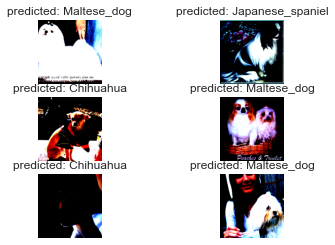

In [18]:
style.use('seaborn-dark')
visualize_model(mdl_new)